### Step 1: Estimate Micasense Image Warp Matrix

In [1]:
# loading modules

In [2]:
import micasense.metadata as metadata
import micasense.imageset as imageset
import micasense.utils as msutils
import micasense.plotutils as plotutils 
import micasense.capture as capture
import micasense.dls as dls
from micasense.panel import Panel
from micasense.image import Image

from PIL import Image as Img
import numpy as np
import os, glob
import math
import matplotlib.pyplot as plt
import subprocess
import pyzbar.pyzbar as pyzbar

defining inputs (raw images) and outputs (processed images) paths

NOTE: Micasense raw images are put in subfolders every 200 photos. For this code, the raw images were put all in a single folder (called all).  

In [3]:
# put all images in the same folder (reflectance panel and the rest)
path_inputs = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET\all')             

# place to save results
path_outputs = (r'C:\Users\Alfonso\Desktop\20200727_1150AM_Matrice_Micasense_IRT_Tower1\0000SET_processed')         

In [4]:
# Loading all the raw data 

In [5]:
from ipywidgets import FloatProgress, Layout
from IPython.display import display
import micasense.imageset as imageset
import os

## This progress widget is used for display of the long-running process
f = FloatProgress(min=0, max=1, layout=Layout(width='100%'), description="Loading")
display(f)
def update_f(val):
    if (val - f.value) > 0.005 or val == 1: #reduces cpu usage from updating the progressbar by 10x
        f.value=val

# images_dir = os.path.expanduser(os.path.join('~','Downloads','RedEdgeImageSet','0000SET'))
%time imgset = imageset.ImageSet.from_directory(path_inputs, progress_callback=update_f)

FloatProgress(value=0.0, description='Loading', layout=Layout(width='100%'), max=1.0)

Wall time: 3min 24s


In [6]:
import pandas as pd

data, columns = imgset.as_nested_lists()
print("Columns: {}".format(columns))
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

Columns: ['timestamp', 'latitude', 'longitude', 'altitude', 'capture_id', 'dls-yaw', 'dls-pitch', 'dls-roll', 'irr-475', 'irr-560', 'irr-668', 'irr-842', 'irr-717', 'irr-11000']


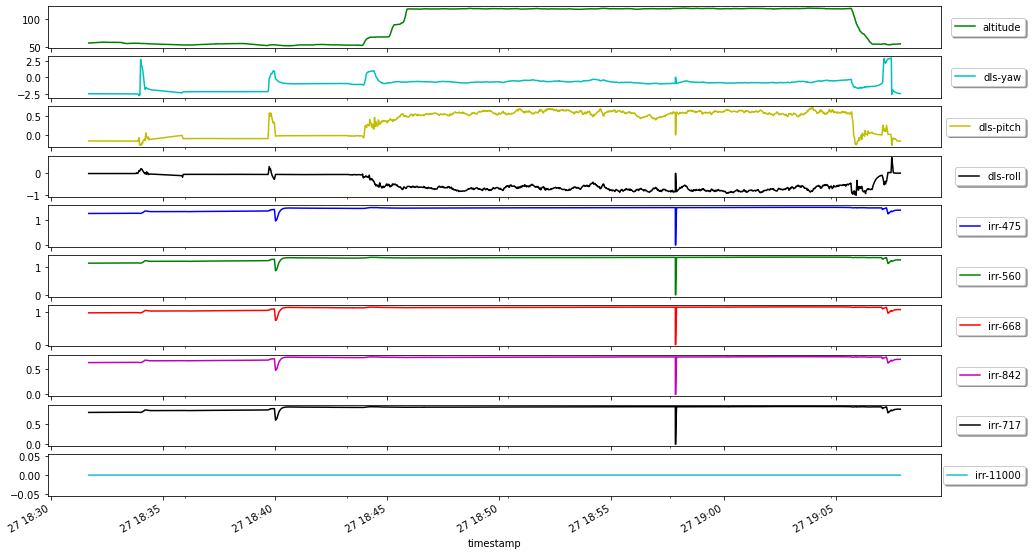

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline
ax=df.plot(y=columns[3:], subplots=True, figsize=(16, 10), style=['g','c','y','k','b','g','r','m','k']);
for a in ax:
    a.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1, fancybox=True, shadow=True);

In [22]:
df

,latitude,longitude,altitude,capture_id,dls-yaw,dls-pitch,dls-roll,irr-475,irr-560,irr-668,irr-842,irr-717,irr-11000
0,36.849167,-120.178331,57.485,E2R5j070461Gtj8LwRRx,-2.505806,-0.162725,-0.005824,1.285045,1.148100,0.985967,0.635343,0.771723,0
1,36.849167,-120.178332,57.548,Cg0UxT4NCLxRN3gk3GsU,-2.505434,-0.162658,-0.005721,1.285159,1.148196,0.986044,0.635392,0.771784,0
2,36.849168,-120.178332,57.587,Eb3ng7b3V0ozfNR5XdaE,-2.505309,-0.162508,-0.005649,1.285177,1.148211,0.986056,0.635399,0.771793,0
3,36.849168,-120.178333,57.654,MePn6AlJuhOH6xAOU2xY,-2.506301,-0.162622,-0.005544,1.285143,1.148179,0.986026,0.635380,0.771769,0
4,36.849168,-120.178334,57.698,i2wQ5dV0Z5GBiqTXX7IB,-2.505784,-0.162841,-0.005479,1.285161,1.148193,0.986036,0.635386,0.771777,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,36.849167,-120.178308,55.686,kvXhXGFe24b9sWVaJANs,-2.436638,-0.164966,0.011237,1.419857,1.266984,1.086551,0.699901,0.850437,0
1670,36.849167,-120.178308,55.769,IQDSMc6PSZ8XMKhfj7sv,-2.447512,-0.165134,0.011132,1.419712,1.266873,1.086474,0.699854,0.850377,0
1671,36.849168,-120.178308,55.810,KRzf4L35DBWzokLS0RON,-2.455893,-0.165395,0.010765,1.419587,1.266773,1.086400,0.699809,0.850319,0
1672,36.849168,-120.178308,55.874,iZxLbiliEQsrdOiUBdC4,-2.467515,-0.165678,0.010454,1.419208,1.266450,1.086137,0.699641,0.850113,0


In [25]:
# selecting the image at the highest elevation
df.reset_index(drop=True, inplace=True)

flight_image= imgset.captures[df['altitude'].idxmax()]


In [ ]:
# Producing the warp matrix for processing all images

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import micasense.imageutils as imageutils
import micasense.plotutils as plotutils


img_type = "reflectance"

warp_mode = cv2.MOTION_HOMOGRAPHY
warp_matrices = flight_image.get_warp_matrices()

cropped_dimensions,edges = imageutils.find_crop_bounds(flight_image,warp_matrices)
im_aligned = imageutils.aligned_capture(flight_image, warp_matrices, warp_mode, cropped_dimensions, None, img_type=img_type)

print("warp_matrices={}".format(warp_matrices))

warp_matrices=[array([[ 1.01091439e+00, -9.69521251e-04, -6.45529349e+00],
       [ 1.31355063e-03,  1.00981957e+00,  1.93919453e+01],
       [ 1.18381037e-06, -5.76220442e-07,  1.00000000e+00]]), array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]]), array([[ 1.00965277e+00,  1.61969135e-03, -1.73144964e+01],
       [-7.25967459e-04,  1.00917561e+00, -2.49945847e+00],
       [ 7.62624383e-07,  3.10907640e-07,  1.00000000e+00]]), array([[ 1.00730100e+00, -1.35214962e-03, -2.70427074e+01],
       [ 1.60875061e-03,  1.00632628e+00, -9.92720660e+00],
       [ 3.44336896e-07, -1.46832803e-09,  1.00000000e+00]]), array([[ 1.00386265e+00, -1.72196860e-03, -6.94073993e+00],
       [ 2.11254413e-03,  1.00240003e+00, -1.06110879e+00],
       [ 1.42011355e-06, -6.82290890e-07,  1.00000000e+00]]), array([[ 6.36853519e-02, -5.45081381e-04,  1.39300206e+01],
       [ 6.94401660e-05,  6.30072346e-02,  1.30890127e+01],
       [-2.82248369e-06, -3.87916867e-06,  1.00000000e+00]])]


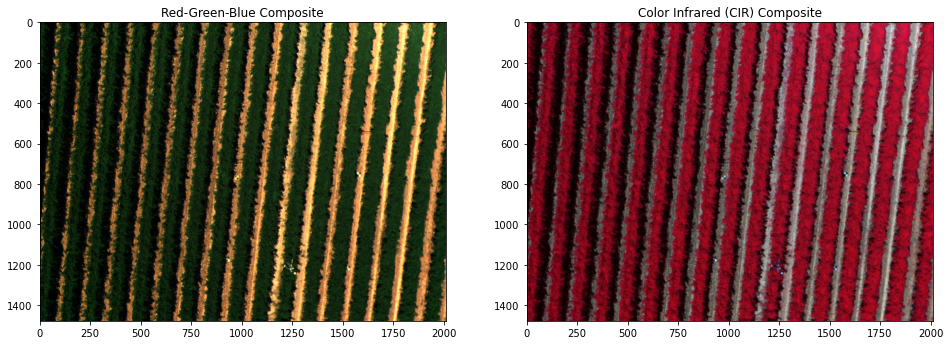

In [29]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],flight_image.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

In [ ]:
# cells below under review, not necessary at this point

In [5]:
# identify one reflectance panel image name. 

wp_image = glob.glob(os.path.join(path_inputs, 'IMG_0120_*.tif'))
# # print(image_names)
white_panel = capture.Capture.from_filelist(wp_image)
print(white_panel.band_names())

['Blue', 'Green', 'Red', 'NIR', 'Red edge', 'LWIR']


In [5]:
# detecting panel in all optical bands

img = Image(wp_image[0])
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
    panelCorner0 = panel.panel_corners()

if not panel.panel_detected():
    raise IOError("Panel Not Detected!")


pnl = Panel(img,panelCorners = panelCorner0)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

# pnl.plot();

Found automatic calibration image
Panel found: True
Panel serial: RP04-1943269-OB
QR Code Corners:
None
Panel mean raw pixel value: 31965.724815119145
Panel raw pixel standard deviation: 895.9533460553582
Panel region pixel count: 24340
Panel region saturated pixel count: 24340


In [6]:
    
img = Image(wp_image[1])
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
    panelCorner1 = panel.panel_corners()

if not panel.panel_detected():
    raise IOError("Panel Not Detected!")

pnl = Panel(img,panelCorners = panelCorner1)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

# pnl.plot();

Found automatic calibration image
Panel found: True
Panel serial: RP04-1943269-OB
QR Code Corners:
None
Panel mean raw pixel value: 30708.14775714755
Panel raw pixel standard deviation: 1028.003865539815
Panel region pixel count: 24344
Panel region saturated pixel count: 24344


In [7]:
img = Image(wp_image[2])
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
    panelCorner2 = panel.panel_corners()

if not panel.panel_detected():
    raise IOError("Panel Not Detected!")

pnl = Panel(img,panelCorners = panelCorner2)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

# pnl.plot();

Found automatic calibration image
Panel found: True
Panel serial: RP04-1943269-OB
QR Code Corners:
None
Panel mean raw pixel value: 28193.103220311485
Panel raw pixel standard deviation: 929.0608648188636
Panel region pixel count: 24656
Panel region saturated pixel count: 24656


In [8]:
img = Image(wp_image[3])
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
    panelCorner3 = panel.panel_corners()

if not panel.panel_detected():
    raise IOError("Panel Not Detected!")

pnl = Panel(img,panelCorners = panelCorner3)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

# pnl.plot();

Found automatic calibration image
Panel found: True
Panel serial: RP04-1943269-OB
QR Code Corners:
None
Panel mean raw pixel value: 32070.178019720624
Panel raw pixel standard deviation: 844.3299154642854
Panel region pixel count: 24340
Panel region saturated pixel count: 24340


In [9]:
img = Image(wp_image[4])
if img.auto_calibration_image:
    print("Found automatic calibration image")
    panel = Panel(img)
    panelCorner4 = panel.panel_corners()

if not panel.panel_detected():
    raise IOError("Panel Not Detected!")

pnl = Panel(img,panelCorners = panelCorner4)
print("Panel found: {}".format(pnl.panel_detected()))
print("Panel serial: {}".format(pnl.serial))
print("QR Code Corners:\n{}".format(pnl.qr_corners()))
mean, std, count, saturated_count = pnl.raw()
print("Panel mean raw pixel value: {}".format(mean))
print("Panel raw pixel standard deviation: {}".format(std))
print("Panel region pixel count: {}".format(count))
print("Panel region saturated pixel count: {}".format(count))

# pnl.plot();

Found automatic calibration image
Panel found: True
Panel serial: RP04-1943269-OB
QR Code Corners:
None
Panel mean raw pixel value: 30484.233688415447
Panel raw pixel standard deviation: 868.6940399934168
Panel region pixel count: 24032
Panel region saturated pixel count: 24032


In [10]:
print(panelCorner0)
print(panelCorner1)
print(panelCorner2)
print(panelCorner3)
print(panelCorner4)

[[1405  633]
 [1561  635]
 [1563  479]
 [1407  477]]
[[1555  613]
 [1711  617]
 [1713  461]
 [1557  457]]
[[1546  518]
 [1702  520]
 [1706  362]
 [1550  360]]
[[1381  509]
 [1537  511]
 [1539  355]
 [1383  353]]
[[1465  561]
 [1619  563]
 [1623  407]
 [1469  405]]


In [11]:
panelCorners = [[[1405,  633],
                 [1561,  635],
                 [1563,  479],
                 [1407,  477]],
                [[1555,  613],
                 [1711,  617],
                 [1713,  461],
                 [1557,  457]],
                [[1546,  518],
                 [1702,  520],
                 [1706,  362],
                 [1550,  360]],
                [[1381,  509],
                 [1537,  511],
                 [1539,  355],
                 [1383,  353]],
                [[1465,  561],
                 [1619,  563],
                 [1623,  407],
                 [1469,  405]]]


print(panelCorners)

white_panel.set_panelCorners(panelCorners)

[[[1405, 633], [1561, 635], [1563, 479], [1407, 477]], [[1555, 613], [1711, 617], [1713, 461], [1557, 457]], [[1546, 518], [1702, 520], [1706, 362], [1550, 360]], [[1381, 509], [1537, 511], [1539, 355], [1383, 353]], [[1465, 561], [1619, 563], [1623, 407], [1469, 405]]]


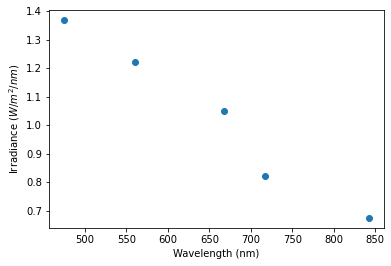

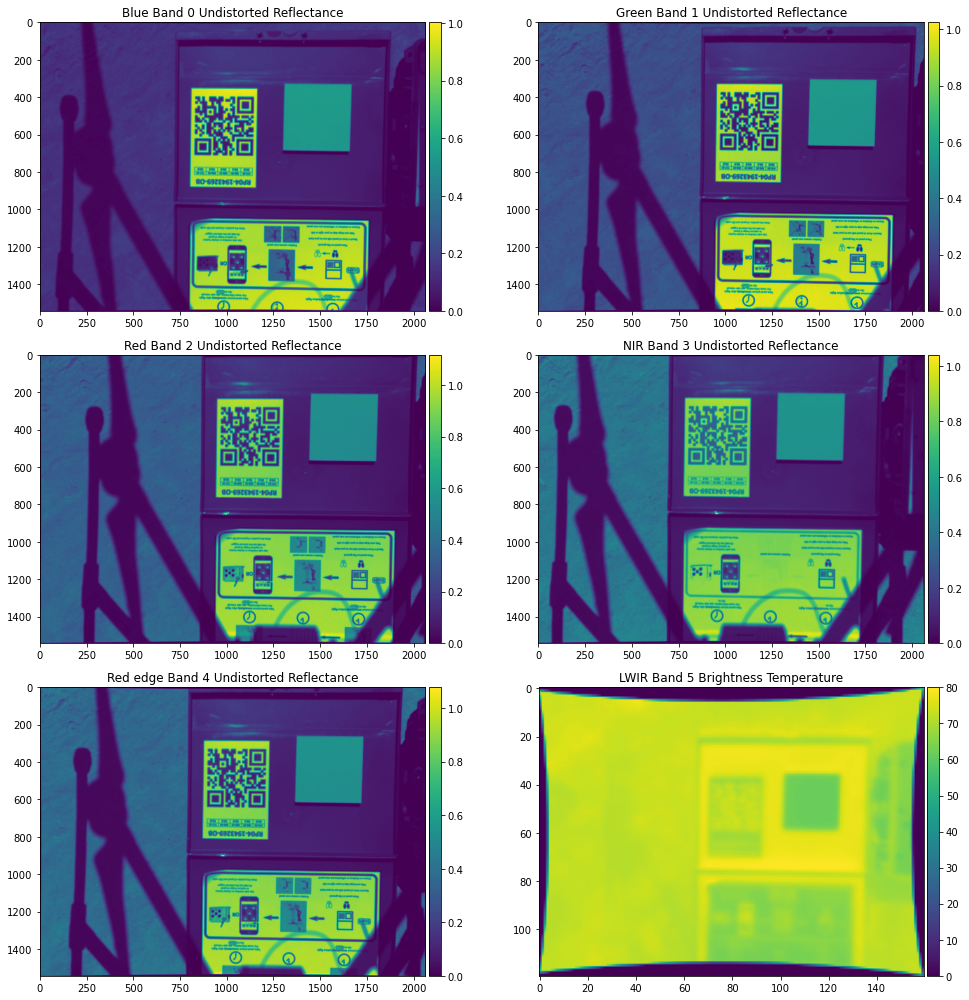

In [12]:
#doğrulanmış DLS2 okumaları - ground seviyesinde
dls_irradiances = []
center_wavelengths = []
for img in white_panel.images[:-1]:

    dls_irr = img.horizontal_irradiance
    dls_irradiances.append(dls_irr)
    center_wavelengths.append(img.center_wavelength)



plt.scatter(center_wavelengths, dls_irradiances)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Irradiance ($W/m^2/nm$)')
plt.show();

#cap.plot_undistorted_reflectance(dls_irradiances)
#this must be for specific Micasense panel
panel_reflectance_by_band = [0.54, 0.54, 0.54, 0.53, 0.54]  # Altum band_index değerleri

panel_radiances = np.array(white_panel.panel_radiance())
# print(panel_radiances)
irr_from_panel = math.pi * panel_radiances / panel_reflectance_by_band
dls_correction = irr_from_panel / dls_irradiances
white_panel.plot_undistorted_reflectance(dls_irradiances * dls_correction)

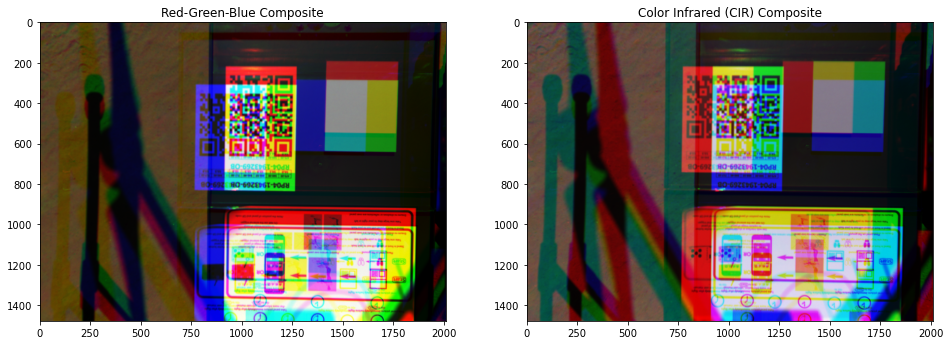

In [14]:
# figsize=(30,23) # use this size for full-image-resolution display
figsize=(16,13)   # use this size for export-sized display

rgb_band_indices = [2,1,0]
cir_band_indices = [3,2,1]

# Create an empty normalized stack for viewing
im_display = np.zeros((im_aligned.shape[0],im_aligned.shape[1],white_panel.num_bands+1), dtype=np.float32 )

im_min = np.percentile(im_aligned[:,:,0:2].flatten(),  0.1)  # modify with these percentilse to adjust contrast
im_max = np.percentile(im_aligned[:,:,0:2].flatten(), 99.9)  # for many images, 0.5 and 99.5 are good values

for i in range(0,im_aligned.shape[2]):
    if img_type == 'reflectance':
        # for reflectance images we maintain white-balance by applying the same display scaling to all bands
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i], im_min, im_max)
    elif img_type == 'radiance':
        # for radiance images we do an auto white balance since we don't know the input light spectrum by
        # stretching each display band histogram to it's own min and max
        im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

rgb = im_display[:,:,rgb_band_indices]
# for cir false color imagery, we normalize the NIR,R,G bands within themselves, which provides
# the classical CIR rendering where plants are red and soil takes on a blue tint
for i in cir_band_indices:
    im_display[:,:,i] =  imageutils.normalize(im_aligned[:,:,i])

cir = im_display[:,:,cir_band_indices]
fig, axes = plt.subplots(1, 2, figsize=figsize)
axes[0].set_title("Red-Green-Blue Composite")
axes[0].imshow(rgb)
axes[1].set_title("Color Infrared (CIR) Composite")
axes[1].imshow(cir)
plt.show()

In [16]:
import micasense.imageset as imageset

import pandas as pd
data, columns = imgset.as_nested_lists()
print("Columns: {}".format(columns))
df = pd.DataFrame.from_records(data, index='timestamp', columns=columns)

Columns: ['timestamp', 'latitude', 'longitude', 'altitude', 'capture_id', 'dls-yaw', 'dls-pitch', 'dls-roll', 'irr-475', 'irr-560', 'irr-668', 'irr-842', 'irr-717', 'irr-11000']


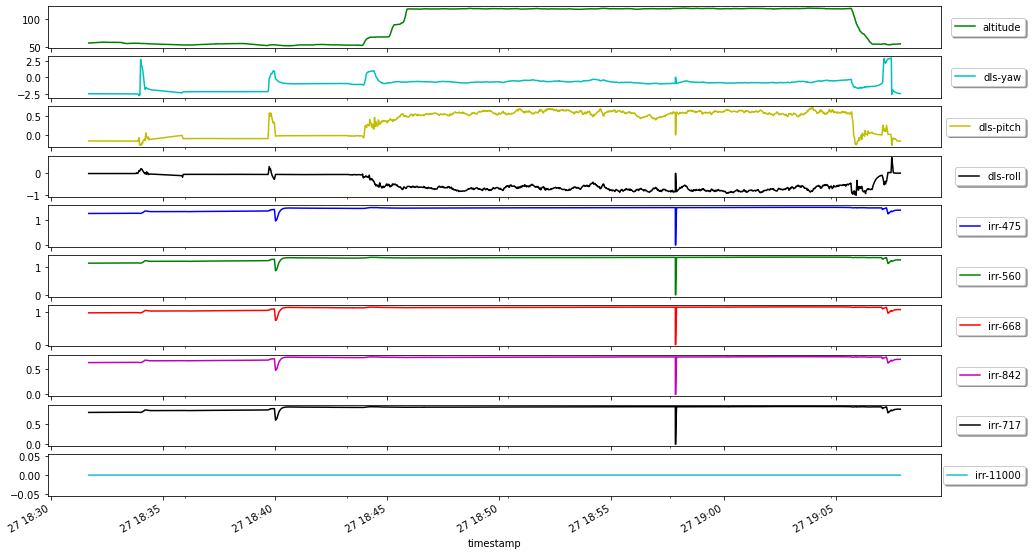

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline
ax=df.plot(y=columns[3:], subplots=True, figsize=(16, 10), style=['g','c','y','k','b','g','r','m','k']);
for a in ax:
    a.legend(loc='right', bbox_to_anchor=(1.1, 0.5), ncol=1, fancybox=True, shadow=True);

53.0


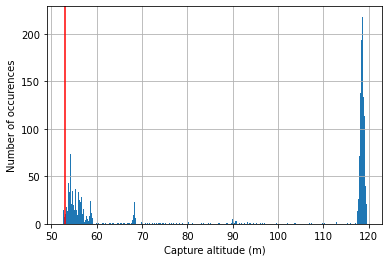

In [30]:
# plot the histogram of the altitude data
df.altitude.hist(bins=300);
# find the altitude above which the flight images occur
cutoff_altitude = round(df.altitude.mean()-41,0)
print(cutoff_altitude)
plt.axvline(x=cutoff_altitude,c='r');
plt.xlabel('Capture altitude (m)');
plt.ylabel('Number of occurences');